# Transformer模型测试任务--copy任务
### 实现copy任务的四部曲：
1. 构建数据集生成器
2. 获得Transformer模型及其优化器和损失函数
3. 运行模型进行训练和评估
4. 使用模型进行贪婪解码

> copy任务介绍：
> - 任务描述：针对数字序列进行学习，学习的最终目标是使输出与输入序列相同。如输入[1,5,8,9,3],输出也是[1,5,8,9,3]
> - 任务意义：copy任务在模型基础测试中具有重要意义，因为copy操作对于模型来讲是一条明显的规律，因此模型能否在短时间内，小数据集中学会它，可以帮助我们断定模型所有过程是否正常，是否已具备基本学习能力。

In [1]:
"""构建数据集生成器"""
from pyitcast.transformer_utils import Batch
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable

def data_generator(V, batch_size, num_batch):
    for i in range(num_batch):
        data = torch.from_numpy(np.random.randint(1,V,size=(batch_size,10)))
        # 第0位设置为1作为起始标志
        data[:,0] = 1
        source = Variable(data,requires_grad = False)
        target = Variable(data,requires_grad = False)
        
        #使用Batch对source和target进行对应批次的掩码张量生成
        yield Batch(source,target)

In [2]:
# 输入参数与调用
V = 11
batch_size = 20
num_batch = 30

if __name__ == '__main__':
    res = data_generator(V,batch_size,num_batch)
    print(res)

<generator object data_generator at 0x00000194516B0B80>


In [3]:
# 导入优化器工具包get_std_opt, 该工具用于获得标准的针对Transformer模型的优化器 
# 该标准优化器基于Adam优化器, 使其对序列到序列的任务更有效.
from  TransformerModel import make_mode
from pyitcast.transformer_utils import get_std_opt

# 导入标签平滑工具包, 该工具用于标签平滑, 标签平滑的作用就是小幅度的改变原有标签值的值域
# 因为在理论上即使是人工的标注数据也可能并非完全正确, 会受到一些外界因素的影响而产生一些微小的偏差
# 因此使用标签平滑来弥补这种偏差, 减少模型对某一条规律的绝对认知, 以防止过拟合. 通过下面示例了解更多.
from pyitcast.transformer_utils import LabelSmoothing

# 导入损失计算工具包, 该工具能够使用标签平滑后的结果进行损失的计算, 
# 损失的计算方法可以认为是交叉熵损失函数.
from pyitcast.transformer_utils import SimpleLossCompute

# 使用make_model获得model
model = make_mode(V,V,N=2)

# 使用get_std_opt获得模型优化器
model_optimizer = get_std_opt(model)

# 使用LabelSmoothing获得标签平滑对象
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)

# 使用SimpleLossCompute获得利用标签平滑结果的损失计算方法
loss = SimpleLossCompute(model, criterion, model_optimizer)


D:\Edith_ZYN\MLResource\Transformer\TransformerModel.py:229: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(p)
D:\Program Files\anaconda3\envs\myenv\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


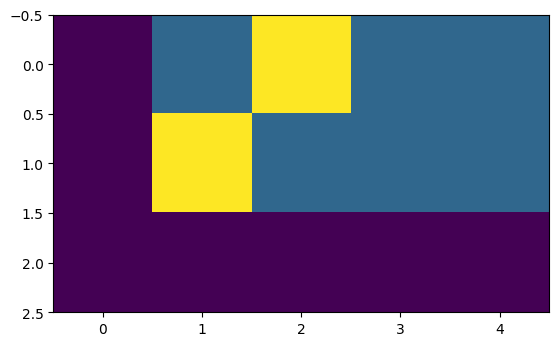

In [10]:
from pyitcast.transformer_utils import LabelSmoothing
import matplotlib.pyplot as plt
%matplotlib inline
# 使用LabelSmoothing实例化一个crit对象.
# 第一个参数size代表目标数据的词汇总数, 也是模型最后一层得到张量的最后一维大小
# 这里是5说明目标词汇总数是5个. 第二个参数padding_idx表示要将那些tensor中的数字
# 替换成0, 一般padding_idx=0表示不进行替换. 第三个参数smoothing, 表示标签的平滑程度
# 如原来标签的表示值为1, 则平滑后它的值域变为[1-smoothing, 1+smoothing].
crit = LabelSmoothing(size=5, padding_idx=0, smoothing=0.5)

# 假定一个任意的模型最后输出预测结果和真实结果
predict = Variable(torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]]))

# 标签的表示值是0，1，2
target = Variable(torch.LongTensor([2, 1, 0]))

# 将predict, target传入到对象中
crit(predict, target)

# 绘制标签平滑图像
plt.imshow(crit.true_dist)
plt.show()

In [11]:
from pyitcast.transformer_utils import run_epoch

def run(model, loss, epochs=10):
    """模型训练函数, 共有三个参数, model代表将要进行训练的模型
       loss代表使用的损失计算方法, epochs代表模型训练的轮数"""

    # 遍历轮数
    for epoch in range(epochs):
        # 模型使用训练模式, 所有参数将被更新
        model.train()
        # 训练时, batch_size是20
        run_epoch(data_generator(V, 8, 20), model, loss)

        # 模型使用评估模式, 参数将不会变化 
        model.eval()
        # 评估时, batch_size是5
        run_epoch(data_generator(V, 8, 5), model, loss)

In [12]:
from pyitcast.transformer_utils import greedy_decode 


def run(model, loss, epochs=10):
    for epoch in range(epochs):
        model.train()

        run_epoch(data_generator(V, 8, 20), model, loss)

        model.eval()

        run_epoch(data_generator(V, 8, 5), model, loss)

    # 模型进入测试模式
    model.eval()

    # 假定的输入张量
    source = Variable(torch.LongTensor([[1,3,2,5,4,6,7,8,9,10]]))

    # 定义源数据掩码张量, 因为元素都是1, 在我们这里1代表不遮掩
    # 因此相当于对源数据没有任何遮掩.
    source_mask = Variable(torch.ones(1, 1, 10))

    # 最后将model, src, src_mask, 解码的最大长度限制max_len, 默认为10
    # 以及起始标志数字, 默认为1, 我们这里使用的也是1
    result = greedy_decode(model, source, source_mask, max_len=10, start_symbol=1)
    print(result)


if __name__ == '__main__':
    run(model, loss)


RuntimeError: The size of tensor a (11) must match the size of tensor b (512) at non-singleton dimension 2